In [1]:
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import compute_ior_gradient, generate_initial_wavefront, simulate_wavefront_propagation, remove_under_floor, normalize_by_max
from common.plot import Plotter
from data.octree import Octree
from data.mlp import MLP
from data.np_grid import *
import taichi as ti
from scipy import ndimage
from data.siren import *
# debug=True to check boundary access
ti.init(arch=ti.gpu)

%load_ext autoreload
%autoreload 2

# Commented because the compatibility of this extension is not good
%matplotlib widget 

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda


In [2]:
# from PIL import Image
# import matplotlib.pyplot as plt
# 


# cameraman = Image.open("cameraman.jpg").convert("L")
# width, height = cameraman.size
# floor_height = 40
# cropped_image = cameraman.crop((0, 0, width, height - floor_height))
# cropped_size = cropped_image.size[1], cropped_image.size[0]
# # cropped_image.show()
# print(cropped_size)

In [3]:
# torch.cuda.empty_cache()
# cameraman_data = ImageFitting(cropped_image, cropped_size)
# dataloader = DataLoader(cameraman_data, batch_size=1, pin_memory=True, num_workers=0)

# img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
#                   hidden_layers=3, outermost_linear=True)
# img_siren.cuda()

# total_steps = 49 # Since the whole image is our dataset, this just means 500 gradient descent steps.
# steps_til_summary = 16

# optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

# model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

# for step in range(total_steps):
#     model_output = img_siren(model_input)
#     loss = ((model_output - ground_truth)**2).mean()

#     if step % steps_til_summary == 0 and step > 0:
#         print("Step %d, Total loss %0.6f" % (step, loss))
#         # img_grad = gradient(model_output, coords)
#         # img_laplacian = laplace(model_output, coords)

#         plt.figure()
#         plt.imshow(model_output.cpu().view(cropped_size).detach().numpy())
#         plt.show()

#     optim.zero_grad()
#     loss.backward()
#     optim.step()

In [4]:
# result = model_output.cpu().view(cropped_size).detach().numpy()
# print(cropped_size)

## 1. Load voxel model

In [5]:
NUM_XYZ = (128, 128, 128)
scene, floor_height = setup_voxel_scene(*NUM_XYZ)

Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


## 2. Path tracing render

In [6]:
# scene.finish()

## 3. Perform light simulation

[ Loaded ] irradiance and local direction from c:\Users\yaozi\Desktop\Voxel-Render\data\saves\NP(irrad,loc_dir)(3-samplers).npz


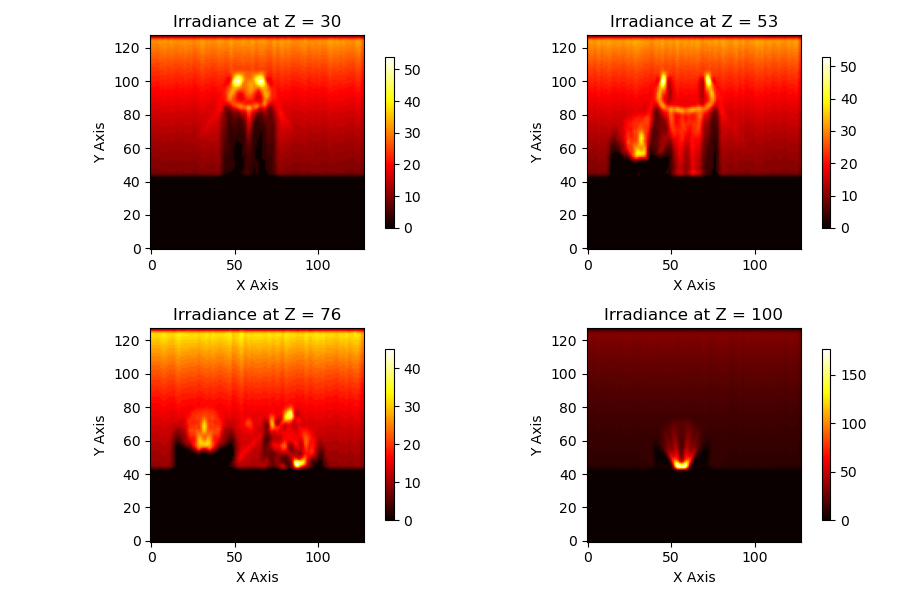

In [7]:
assert scene.ior.shape == NUM_XYZ, "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter = Plotter(sampler_multiplier, floor_height, scene.ior)
# plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
# plotter.plot_gradient(scene.gradient, threshold=0.01, alpha=0.01)
load = True
if load and irrad_loc_dir_save_exists(sampler_multiplier):
    raw_irradiance, scene.local_diretion = load_irrad_loc_dir(sampler_multiplier)    
else:
    step_size = 0.3 * (NUM_XYZ[1] / 100)
    num_steps = int(1.0 * (NUM_XYZ[1]  / step_size))
    num_show_images = 0
    initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, *NUM_XYZ)
    raw_irradiance, scene.local_diretion = simulate_wavefront_propagation(scene.ior, scene.gradient, scene.attenuation,
                                                    initial_wavefront_pos, initial_wavefront_dir, plotter, 
                                                    num_steps, step_size, num_show_images)
    save_irrad_loc_dir(raw_irradiance, scene.local_diretion, sampler_multiplier)

raw_irradiance = remove_under_floor(raw_irradiance, floor_height=floor_height)
scene.irradiance = ndimage.gaussian_filter(raw_irradiance, sigma=1.0) 
# plotter.plot_irradiance_slices(raw_irradiance, threshold=3, num_slices=4, z_start=30, z_end=100)

normalized_irradiance = normalize_by_max(scene.irradiance) #scene.irradiance #
plotter.plot_irradiance_slices(normalized_irradiance, threshold=3, num_slices=4, z_start=30, z_end=100)

(128, 84, 128)


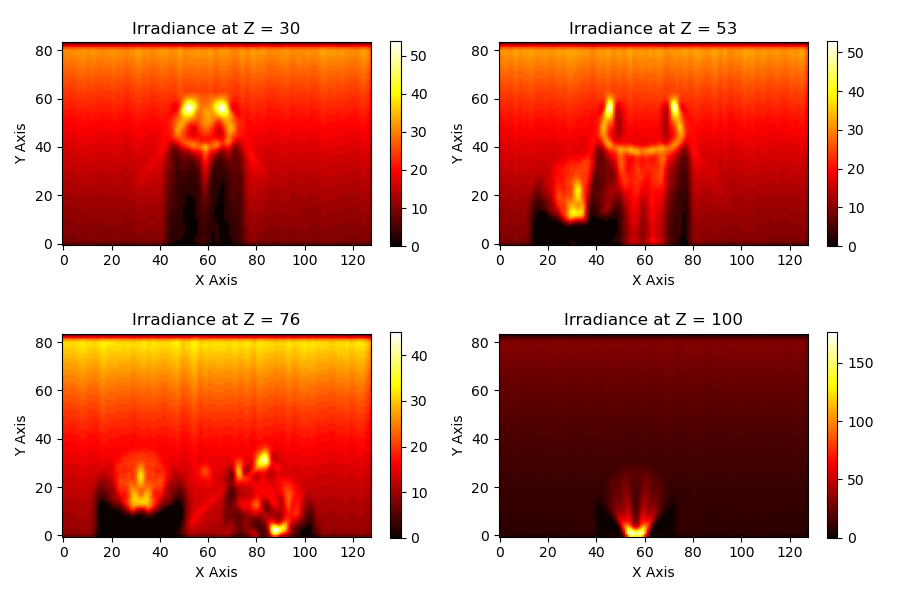

In [8]:
target_size = 128
compress_factor = 128 // target_size

# 使用数组切片提取所需的元素
sliced_arr = normalized_irradiance[::compress_factor, ::compress_factor, ::compress_factor]

# 使用数组重塑将切片后的数组调整为目标尺寸
input_arr = sliced_arr[:target_size, int(floor_height / compress_factor):target_size, :target_size]
print(input_arr.shape)
plotter.plot_irradiance_slices(input_arr, threshold=3, num_slices=4, z_start=30/compress_factor, z_end=100/compress_factor)

In [9]:
torch.cuda.empty_cache()
from torch.utils.data import DataLoader, Dataset, RandomSampler

batch_size = 20000

irrad_data = VoxelFitting(input_arr, sidelength=input_arr.shape)
dataloader = DataLoader(irrad_data, batch_size=batch_size, sampler=RandomSampler(irrad_data), 
                        pin_memory=True)
# model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

siren = Siren(in_features=3, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True,
                  first_omega_0=20, hidden_omega_0=20)
siren.cuda()

total_steps = 20
show_epoch_interval = 4

optim = torch.optim.Adam(lr=5e-4, params=siren.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.2, patience=5)

siren.train()
for cur_epoch in range(total_steps):
    epoch_loss = 0
    for model_input, ground_truth in dataloader:
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
        model_output = siren(model_input)
        model_output = model_output.view(ground_truth.shape)
        loss = ((model_output - ground_truth)**2).mean()
        epoch_loss += loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    epoch_loss /= len(dataloader)
    scheduler.step(epoch_loss)

    if cur_epoch % show_epoch_interval == 0 or cur_epoch == total_steps - 1:
        print("Epoch: {} \tAverage Loss: {:.4f} \tLearning Rate: {}".format(cur_epoch, epoch_loss, 
                                                                            scheduler.get_last_lr()))

Epoch: 0 	Average Loss: 266.6085 	Learning Rate: [0.0005]
Epoch: 4 	Average Loss: 23.8321 	Learning Rate: [0.0005]
Epoch: 8 	Average Loss: 13.6177 	Learning Rate: [0.0005]
Epoch: 12 	Average Loss: 11.7623 	Learning Rate: [0.0005]
Epoch: 16 	Average Loss: 10.7999 	Learning Rate: [0.0005]
Epoch: 20 	Average Loss: 10.2416 	Learning Rate: [0.0005]


In [ ]:
model_input.shape, model_output.shape

### Inference

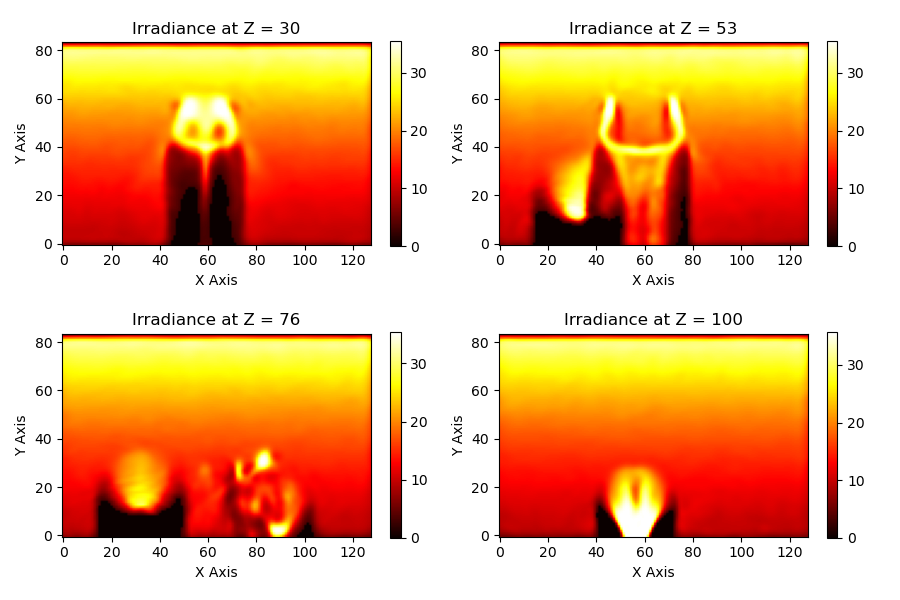

In [10]:
torch.cuda.empty_cache()
infer_coord = get_mgrid(input_arr.shape, dim=3).cuda()
result = siren(infer_coord).view(input_arr.shape).detach().cpu().numpy()
plotter.plot_irradiance_slices(result, threshold=3, num_slices=4, z_start=30/compress_factor, z_end=100/compress_factor)

## 4. Store irradiance in Neural network irradiance （MLP）

In [ ]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier=sampler_multiplier, num_epoches=30)

In [ ]:
# Visualize the predicted irradiance field
predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

## 5. SIREN

## 6. Store irradiance in octree

In [ ]:
octree = Octree(threshold=int(0.6 * (sampler_multiplier**3)))
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

In [ ]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

## 6. Ray marching render